In [45]:
import numpy as np
import math
import cv2
from matplotlib import pyplot as plt
import time

In [60]:
camParams = np.load('../Calib/camParams.npy')
camParams = np.load('../Calib/distCoeff.npy')

In [6]:
frame2 = cv2.imread('../Tests/Frame2.jpg')
frame3 = cv2.imread('../Tests/Frame2.jpg')
frame4 = cv2.imread('../Tests/Frame2.jpg')
frame5 = cv2.imread('../Tests/Frame2.jpg')

In [11]:
cv2.imshow("frame2", frame2)
cv2.waitKey(0)

-1

In [13]:
gray = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)
nonzero = cv2.findNonZero(gray)
nonzero = np.array(nonzero).reshape(nonzero.shape[0], 2)
nonzero = np.float32(nonzero)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 4, 1.0)
ret,label,center = cv2.kmeans(nonzero,4,None,criteria,4,cv2.KMEANS_RANDOM_CENTERS)

In [15]:
A = nonzero[label.ravel()==0]
B = nonzero[label.ravel()==1]
C = nonzero[label.ravel()==2]
D = nonzero[label.ravel()==3]

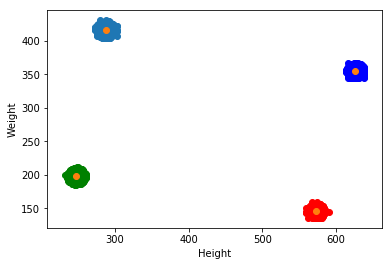

In [16]:
plt.scatter(A[:,0],A[:,1])
plt.scatter(B[:,0],B[:,1],c = 'r')
plt.scatter(C[:,0],C[:,1],c = 'b')
plt.scatter(D[:,0],D[:,1],c = 'g')
plt.xlabel('Height'),plt.ylabel('Weight')
plt.scatter(center[:,0],center[:,1])
plt.show()

In [31]:
center

array([[287.30658, 416.88947],
       [573.3016 , 146.29932],
       [626.45306, 355.2213 ],
       [247.25398, 198.04962]], dtype=float32)

In [27]:
test=frame2.copy()
cv2.circle(test,(int(center[0, 0]),int(center[0, 1])), 3, (0,0,255), -1)
cv2.imshow("frame2", test)
cv2.waitKey(0)

-1

In [29]:
LED=np.zeros((4,2))
origin = ((center[0,0]+center[1,0]+center[2,0]+center[3,0])/4, (center[0,1]+center[1,1]+center[2,1]+center[3,1])/4)
for j in range(4):
    LED[j]=center[j]-origin
LED_lab=np.array([[LED[(LED[:, 0]>0) & (LED[:, 1]>0)][0][0]+origin[0],LED[(LED[:, 0]>0) & (LED[:, 1]>0)][0][1]+origin[1]],
 [LED[(LED[:, 0]<0) & (LED[:, 1]>0)][0][0]+origin[0],LED[(LED[:, 0]<0) & (LED[:, 1]>0)][0][1]+origin[1]],
 [LED[(LED[:, 0]>0) & (LED[:, 1]<0)][0][0]+origin[0],LED[(LED[:, 0]>0) & (LED[:, 1]<0)][0][1]+origin[1]],
 [LED[(LED[:, 0]<0) & (LED[:, 1]<0)][0][0]+origin[0],LED[(LED[:, 0]<0) & (LED[:, 1]<0)][0][1]+origin[1]]])

In [33]:
print(LED_lab.shape)
print(LED_lab)

(4, 2)
[[626.45306396 355.22131348]
 [287.30657959 416.88946533]
 [573.30157471 146.29931641]
 [247.25398254 198.04962158]]


In [56]:
# UR, UL, LR, LL
obj_points = np.array([[0.1, 0.065, 0], [0, 0.065, 0], [0.1, 0, 0], [0, 0, 0]])
cameraMatrix = camParams

In [57]:
cameraMatrix

array([[510.238 ,   0.    ,   0.    ],
       [  0.    , 510.7767,   0.    ],
       [327.4291, 246.0902,   1.    ]])

In [58]:
ret, rvec, tvec = cv2.solvePnP(obj_points, LED_lab, cameraMatrix, 0)

In [59]:
rvec

array([[-0.03994818],
       [ 0.02659258],
       [-0.18411472]])

In [39]:
dst, jac = cv2.Rodrigues(rvec)

In [42]:
dst

array([[ 0.85467402, -0.18797896,  0.48393826],
       [-0.07630324, -0.96750685, -0.24105663],
       [ 0.51352716,  0.16909878, -0.84124637]])

In [46]:
def isRotationMatrix(R) :
    Rt = np.transpose(R)
    shouldBeIdentity = np.dot(Rt, R)
    I = np.identity(3, dtype = R.dtype)
    n = np.linalg.norm(I - shouldBeIdentity)
    return n < 1e-6

def rotationMatrixToEulerAngles(R) :
 
    assert(isRotationMatrix(R))
     
    sy = math.sqrt(R[0,0] * R[0,0] +  R[1,0] * R[1,0])
     
    singular = sy < 1e-6
 
    if  not singular :
        x = math.atan2(R[2,1] , R[2,2])
        y = math.atan2(-R[2,0], sy)
        z = math.atan2(R[1,0], R[0,0])
    else :
        x = math.atan2(-R[1,2], R[1,1])
        y = math.atan2(-R[2,0], sy)
        z = 0
 
    return np.array([x, y, z])

In [50]:
euler_flipped = rotationMatrixToEulerAngles(dst)
euler = np.flip(euler_flipped)